In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import visuals as vs

In [86]:
# /kaggle/input/titanic/
titanic_df = pd.read_csv("train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [87]:
titanic_df.info()
titanic_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [88]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

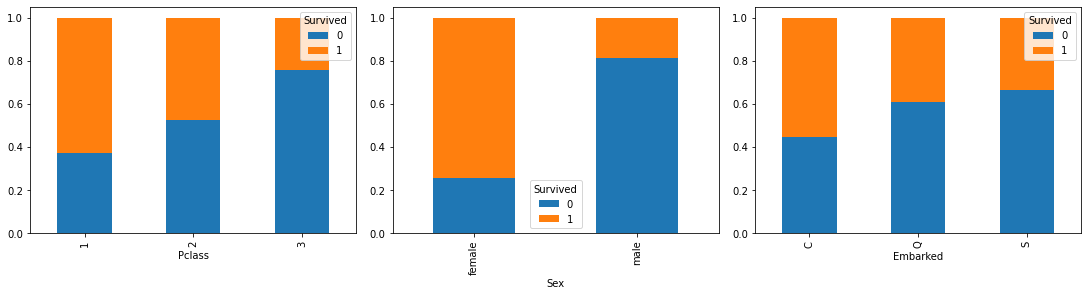

In [89]:
vs.visualize_crosstabs(titanic_df, ['Pclass', 'Sex','Embarked'], 'Survived')

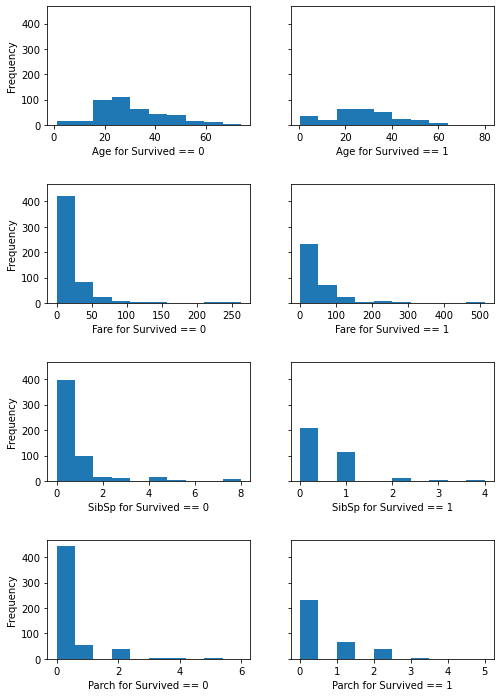

In [90]:
vs.visualize_numerical_feature(titanic_df, ['Age', 'Fare', 'SibSp', 'Parch'], 'Survived')

## Data Precprocessing

In [91]:
import numpy as np
import pandas as pd

class TitanicDataPreProccessor:
    def __init__(self, df: pd.DataFrame):
        # Normalize numeric columns
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        self.scaler = MinMaxScaler()
        self.scaler = self.scaler.fit(df[['Fare', 'Age', 'SibSp', 'Parch']])
        
    def _fill_empty_with_average(self, df: pd.DataFrame, column: str, criteria_column: str) -> pd.DataFrame:
        """Fill empty cells in a column with the average value of the column in the same group

        Args:
            df (pd.DataFrame): input dataframe
            column (str): column to fill
            criteria_column (str): column to group by

        Returns:
            pd.DataFrame: updated dataframe
        """
        # Group by criteria_column and get the mean of column
        if df[column].isnull().sum() == 0:
            return df
        
        values = df[criteria_column].unique()
        for v in values:
            mask = (df[criteria_column] == v)
            mean = df[mask][column].mean()
            print(f"Mean {v} {column} is {mean}")
            df.loc[mask & (df[column].isnull()), column] = mean
        
        return df
            
    def _numpy_arr_to_dataframe(self, nparray: np.ndarray) -> pd.DataFrame:
        """Convert numpy array to dataframe

        Args:
            nparray (np.ndarray): input array

        Returns:
            pd.DataFrame: dataframe
        """
        # Create list of column names with the format "colN" (from 1 to N)
        col_names = ['col' + str(i) for i in np.arange(nparray.T.shape[0]) + 1]
        # Declare pandas.DataFrame object
        df = pd.DataFrame(data=nparray, columns=col_names)
        return df
    

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """ Perform all data preprocessing in one function in order to apply in one step later on testing data

        Inputs:
            df: dataframe

        Returns:
            DataFrame
        """
        # drop empty Embarked row
        mask = df['Embarked'].isnull()
        df.drop(df[mask].index, inplace=True)
        
        # Drop the non-useful columns
        df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)

        # Fill empty Age cells
        df = self._fill_empty_with_average(df, 'Age', 'Sex')
        df = self._fill_empty_with_average(df, 'Fare', 'Pclass')
        
        # Create Sibsp+Parch column
        #titanic_df['SibspParch'] = titanic_df['SibSp'] + titanic_df['Parch']
        #titanic_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
        
        # use polynomial features to increase attributes
        # from sklearn.preprocessing import PolynomialFeatures
        # feat_poly = PolynomialFeatures(degree=1).fit_transform(titanic_df[['Age', 'Fare', 'SibspParch']])
        # feat_poly_df = self._numpy_arr_to_dataframe(feat_poly)
        # feat_poly_df = self._numpy_arr_to_dataframe(self.std_scaler.fit_transform(feat_poly_df))
        # feat_poly_df.reset_index(inplace=True, drop=True)
        # titanic_df = pd.concat([titanic_df, feat_poly_df], axis=1)
        # titanic_df.drop(['Age', 'Fare'], axis=1, inplace=True)
        
        df[['Fare', 'Age', 'SibSp', 'Parch']] = self.scaler.transform(df[['Fare', 'Age', 'SibSp', 'Parch']])
        
        df.reset_index(inplace=True, drop=True)
       
        # OneHotEncode categorical columns
        df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Pclass'])
        
        return df

In [92]:
preproccessor = TitanicDataPreProccessor(titanic_df)
titanic_final = preproccessor.preprocess_data(titanic_df)
titanic_final.head()

Mean male Age is 30.72664459161148
Mean female Age is 27.745173745173744


,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,0.271174,0.125,0.0,0.014151,0,1,0,0,1,0,0,1
1,1,0.472229,0.125,0.0,0.139136,1,0,1,0,0,1,0,0
2,1,0.321438,0.000,0.0,0.015469,1,0,0,0,1,0,0,1
3,1,0.434531,0.125,0.0,0.103644,1,0,0,0,1,1,0,0
4,0,0.434531,0.000,0.0,0.015713,0,1,0,0,1,0,0,1


In [93]:
titanic_final.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Pclass_1      0
Pclass_2      0
Pclass_3      0
dtype: int64

In [94]:
target = titanic_final['Survived']
features = titanic_final.drop(columns=['Survived'], axis=1)

target.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [95]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=target)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 711 samples.
Testing set has 178 samples.


In [96]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = (np.sum(target) + 0) / target.count()
recall = np.sum(target) / np.sum(target)
precision = np.sum(target) / target.count()

g_fscore_beta = 1.25

# TODO: Calculate F-score using the formula above for beta and correct values for precision and recall.
fscore = ((1.0 + g_fscore_beta*g_fscore_beta) * precision * recall) / (((g_fscore_beta*g_fscore_beta) * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3825, F-score: 0.6134]


In [97]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 1
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=g_fscore_beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=g_fscore_beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

GradientBoostingClassifier trained on 7 samples.
GradientBoostingClassifier trained on 71 samples.
GradientBoostingClassifier trained on 711 samples.
DecisionTreeClassifier trained on 7 samples.
DecisionTreeClassifier trained on 71 samples.
DecisionTreeClassifier trained on 711 samples.
MLPClassifier trained on 7 samples.


C:\IDE\Anaconda3\envs\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier trained on 71 samples.
MLPClassifier trained on 711 samples.


d:\github-repos\titanic\visuals.py:127: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


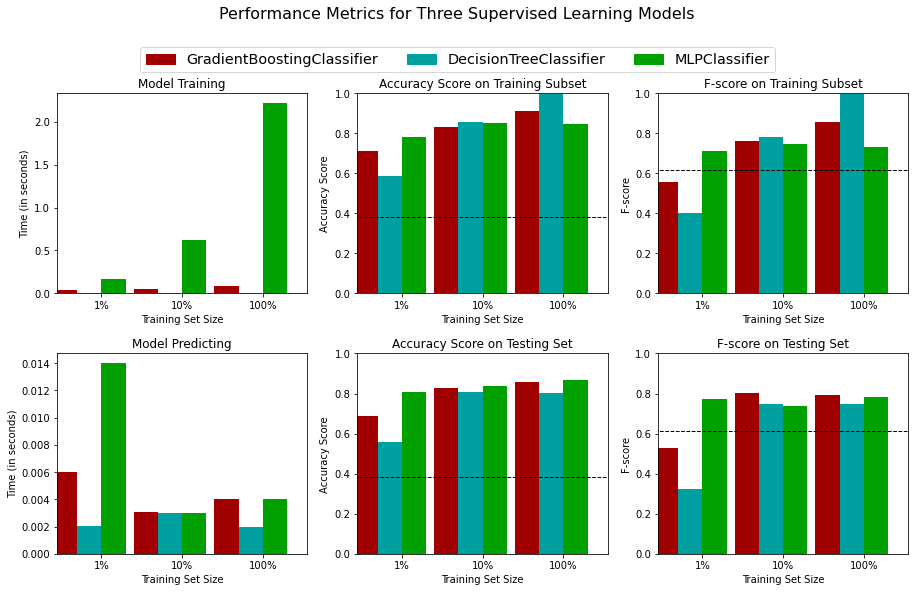

In [98]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "xgboost")

# # TODO: Initialize the three models
#weights = {0: 0.75, 1: 0.25}
clf_A = GradientBoostingClassifier()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = MLPClassifier(random_state=0, max_iter=1000)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [99]:
from sklearn.metrics import accuracy_score, fbeta_score

# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
weight = {1: 0.384, 0: 0.616}
# clf = GradientBoostingClassifier(random_state=0)
# clf = LogisticRegression(random_state=0, class_weight=weight, max_iter=500)
# clf = KNeighborsClassifier()
# clf = (random_state=0, class_weight=weight)
# clf = AdaBoostClassifier(random_state=0, base_estimator=LogisticRegression(random_state=0, class_weight=weight, max_iter=500))
# clf = xgb.XGBClassifier(random_state=0)
# clf = GaussianProcessClassifier(random_state=0)
clf = MLPClassifier(random_state=0, max_iter=1000)
# clf = DecisionTreeClassifier(random_state=0)


# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

# Hyperparameters tuning, dictionary of parameters to be tuned
# Must include default values for all parameters in the list of values to be tested
if clf.__class__.__name__ == 'DecisionTreeClassifier':
    parameters = {
        'max_depth': [2, 3, 5, 10, 20],
        'min_samples_leaf': [3, 5, 10, 20, 50],
        'criterion': ["gini", "entropy"]
    }
elif clf.__class__.__name__ == 'MLPClassifier':
    parameters = {
        'activation': ['identity', 'logistic', 'relu'],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        
    }
elif clf.__class__.__name__ == 'GaussianProcessClassifier':
    parameters = {
        'max_iter_predict': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    }
elif clf.__class__.__name__ == 'RandomForestClassifier':
    parameters = {
        'n_estimators': [10, 50, 100, 200, 500],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 4, 6, 8, 10],
        
    }
elif clf.__class__.__name__ == 'AdaBoostClassifier':
    parameters = {
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        
    }
elif clf.__class__.__name__ == 'Perceptron':
    parameters = {'penalty': ['l1', 'l2'], 
                  'alpha': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.1, 1, 10, 100]
    }
elif clf.__class__.__name__ == 'XGBClassifier':
    parameters = {
        'eta': [0.001, 0.01, 0.1, 1],
        'max_depth': [3, 5, 7],
        'gamma': [0.1, 0.3, 0.5, 1, 1.5],
        'lambda': [0.01, 0.1, 1, 10, 100]
    }
elif clf.__class__.__name__ == 'KNeighborsClassifier':
    parameters = {
        'n_neighbors' : [1,2,3,4,5,7,9,11,13,15,20],
        'weights' : ['uniform','distance'],
        'metric' : ['minkowski','euclidean','manhattan'],
        'algorithm' : ['auto','ball_tree','kd_tree','brute'],
    }
elif clf.__class__.__name__ == 'GradientBoostingClassifier':
    parameters = {
        'learning_rate': [0.001, 0.01, 0.1, 1, 10],
        'n_estimators': [50, 100, 200, 300, 400],
        "max_depth": [2, 3, 4],
    }
elif clf.__class__.__name__ == 'LogisticRegression':
    parameters = {
        'C': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
elif clf.__class__.__name__ == 'SVC':
    parameters = {
        'C': [0.01, 0.1, 1, 3, 5, 10],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'degree': [3, 4, 5, 7],
    }
elif clf.__class__.__name__ == 'LinearSVC':
    parameters = {
        'C': [0.01, 0.1, 1, 10],
        'dual': ['False', 'True'],
    }
elif clf.__class__.__name__ == 'SGDClassifier':
    parameters = {
        'learning_rate': ['adaptive', 'invscaling'],
        'eta0': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
        'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    }
else:
    raise AttributeError(f'Hyperparameters not set for {clf.__class__.__name__}')


# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=g_fscore_beta)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-after scores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = g_fscore_beta)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = g_fscore_beta)))

# print best model hyperparameters
best_clf

Unoptimized model
------
Accuracy score on testing data: 0.8652
F-score on testing data: 0.7835

Optimized Model
------
Final accuracy score on the testing data: 0.8652
Final F-score on the testing data: 0.7835


MLPClassifier(max_iter=1000, random_state=0)

In [100]:
# Train optimized model on ALL available data. Hopefully that increases accuracy on the test_census.csv predictions
best_clf.fit(features, target)

MLPClassifier(max_iter=1000, random_state=0)

In [101]:
# TODO: Extract the feature importances using .feature_importances_ 
try:
        
    importances = best_clf.feature_importances_
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    feat_imp = pd.DataFrame({"feature": columns,
                            "contribution": values})

    feat_imp.head(10)
except AttributeError:
    print(f'No feature importance available for {best_clf.__class__.__name__} model')


No feature importance available for MLPClassifier model


In [102]:
# Load the Census test dataset
# /kaggle/input/titanic/
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [103]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [104]:
passengerID = test_data['PassengerId']

In [105]:
# Fill empty cell first according to Pclass of it
test_features_final = preproccessor.preprocess_data(test_data)
test_features_final.head()

Mean male Age is 30.27273170731707
Mean female Age is 30.27236220472441
Mean 3 Fare is 12.459677880184334
Mean 2 Fare is 22.20210430107527
Mean 1 Fare is 94.28029719626169


,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.428248,0.000,0.000000,0.015282,0,1,0,1,0,0,0,1
1,0.585323,0.125,0.000000,0.013663,1,0,0,0,1,0,0,1
2,0.773813,0.000,0.000000,0.018909,0,1,0,1,0,0,1,0
3,0.334004,0.000,0.000000,0.016908,0,1,0,0,1,0,0,1
4,0.271174,0.125,0.166667,0.023984,1,0,0,0,1,0,0,1


In [106]:
test_features_final.isnull().sum()

Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Pclass_1      0
Pclass_2      0
Pclass_3      0
dtype: int64

In [107]:
test_predictions = best_clf.predict(test_features_final)

In [108]:
predictions_df = pd.DataFrame({"PassengerId": passengerID,
                               "Survived": test_predictions})

# /kaggle/working/
predictions_df.to_csv("predictions_titanic.csv", index=False)